# Proactive Interference Branch


In [2]:
from glob import glob as glob
from itertools import product

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
task = PurePM(ntokens=3,stimdim=1,seed=np.random.randint(300))
tseq,xseq,yseq = task.gen_ep_data(ntrials=2,ppt=4,switchmaps=True)
print(xseq.reshape(2,-1))
print('inst')
print(tseq.reshape(2,-1))
print('y')
print(yseq.reshape(2,-1))


tensor([[0.9097, 0.3557, 0.0482, 0.9097, 0.0482, 0.0482, 0.9097],
        [0.0482, 0.9097, 0.3557, 0.9097, 0.3557, 0.3557, 0.0482]])
inst
tensor([[0, 1, 2, 0, 0, 0, 0],
        [1, 0, 2, 0, 0, 0, 0]])
y
tensor([[0, 1, 2, 0, 2, 2, 0],
        [1, 0, 2, 0, 2, 2, 1]])


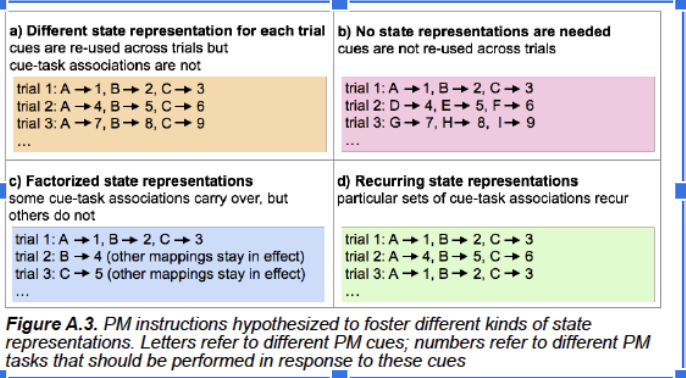

# todo
- run an experiment using the same procedure as the script used in the parasweep but with fixed embeddings. verify that LSTMs can indeed learn the task, and that the problem arises only in the case of trying to generalize to any vector. 

In [9]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)
                           
def train_model(net,task,neps,ntrials=2,seqlen=10):
  """ 
  variable sequence length training
  closed loop randomizing of embedding
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  acc = -np.ones(neps)
  for ep in range(neps):
    # forward prop
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen=seqlen,switchmaps=False)
    yhat_ulog = net(tseq,xseq)
    # eval
    trial_acc = np.mean((maxsoftmax(yhat_ulog) == ytarget).numpy())
    acc[ep] = trial_acc
    # backprop
    for tstep in range(len(tseq)):
      # only backprop response trials
#       if tseq[tstep] == 0:
      optiop.zero_grad()
      loss = lossop(yhat_ulog[tstep],ytarget[tstep])
      loss.backward(retain_graph=True)
      optiop.step()
    if trial_acc>=.99:
      task.randomize_emat()
  return acc

def eval_model(net,task,neps,seqlen=4,ntrials=1):
  """ 
  fixed sequence length eval
  new embedding for every episode
  """
  score = -np.ones((neps,ntrials*(seqlen+task.ntokens)))
#   print('not randomizing')
  for ep in range(neps):
    task.randomize_emat()
    tseq,xseq,ytarget = task.gen_ep_data(ntrials,seqlen)
    yhat_ulog = net(tseq,xseq)
    score[ep] = (maxsoftmax(yhat_ulog) == ytarget).squeeze()
  return score

def mov_avg(arr,wind):
  X = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    X[t] = np.mean(arr[t:t+wind])
  return X

In [62]:
sd = 1
sdim = 10
ntokens = 2

task = PurePM(
        ntokens=ntokens,
        stimdim=sdim,
        seed=sd
)

net = PINet(
        stimdim=sdim,
        stsize=25,
        outdim=ntokens,
        ninstructs=ntokens+1,
        seed=sd
)

In [79]:
np.save?

In [68]:
neps_tr = 10000
tr_acc = train_model(net,task,neps_tr,ntrials=2,seqlen=3)


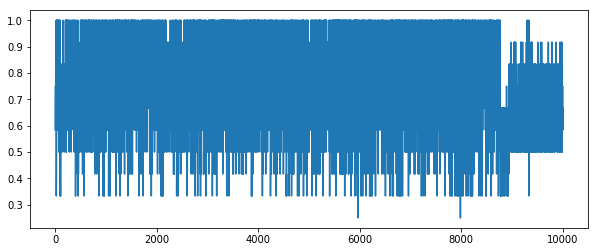

In [78]:
plt.figure(figsize=(10,4))
plt.plot(mov_avg(tr_acc,1))

not randomizing


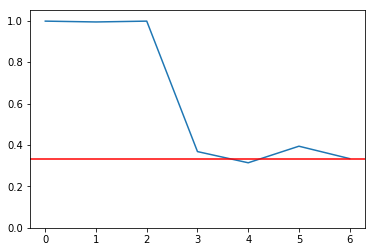

In [76]:
neps_ev = 500
ev_score = eval_model(net,task,neps_ev)
plt.plot(ev_score.mean(0))
plt.ylim(0,1.05)
plt.axhline(.33,c='r')

# load cluster data

In [22]:
glob('model_data/PITask/LSTM_*-ntokens_*-seqlen_*-ntrials_*-switchmaps_*-seed_0-evscore.npy')

['model_data/PITask/LSTM_25-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_25-ntokens_4-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_40-ntokens_4-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_40-ntokens_2-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_25-ntokens_3-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_25-ntokens_5-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_25-ntokens_3-seqlen_4-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_40-ntokens_5-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_40-ntokens_3-seqlen_10-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_40-ntokens_2-seqlen_4-ntrials_2-switchmaps_0-seed_0-evscore.npy',
 'model_data/PITask/LSTM_15-ntokens_2-seqlen_4-ntrials_2-switchmaps_0-seed_0-evsco

### plot eval data

In [4]:
def plot_evacc(fpathL):
  plt.figure(figsize=(10,4))
  for fpath in fpathL:
    subj_acc = np.load(fpath).mean(0)
    ax = plt.gca()
    ax.plot(subj_acc)
    ax.scatter(range(len(subj_acc)),subj_acc)
    ax.set_ylim(0,1.05)
    ax.axhline(1/ntokens,c='r',ls='--')
    ax.axvline(ntokens-.5,c='purple',ls='--')

  fname = 'stsize%i-ntokens%i-seqlen%i'%(stsize,ntokens,seqlen)
  plt.title(fname)
  plt.savefig('figures/PIsweep1/%s'%fname)
  plt.close('all')

stL = [15,25,40]
ntL = [2,3,4,5]
sqL = [4,10,15]

for stsize,ntokens,seqlen in product(stL,ntL,sqL):
  fpathL = glob('model_data/PITask/LSTM_%s-ntokens_%s-seqlen_%s-ntrials_2-switchmaps_0-seed_*-evscore.npy'%(
                stsize,ntokens,seqlen))
  plot_evacc(fpathL)
  


### plot train data

(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


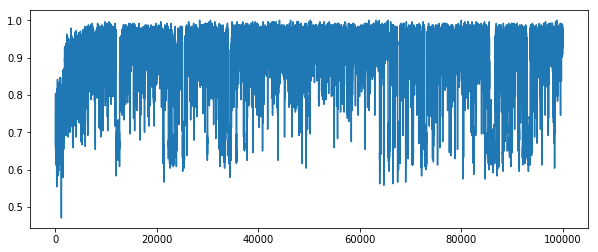

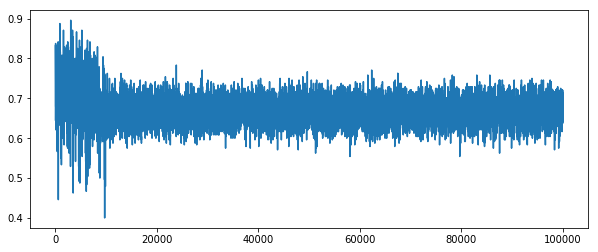

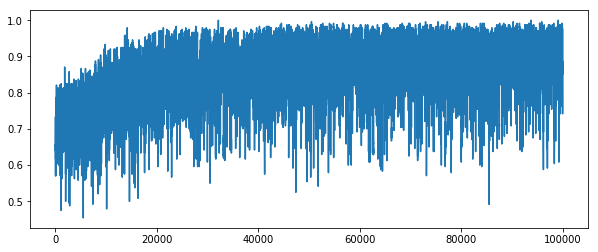

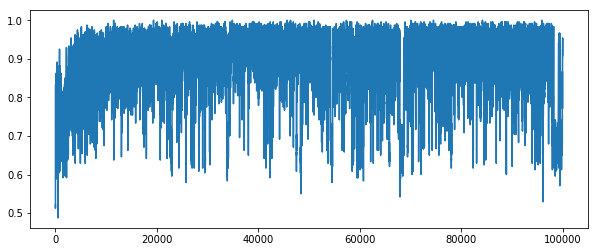

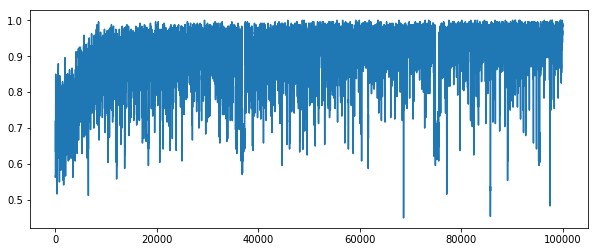

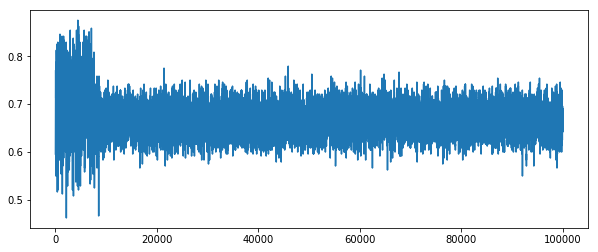

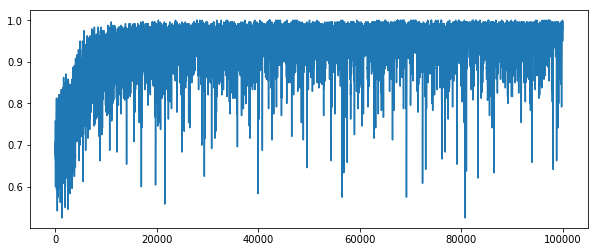

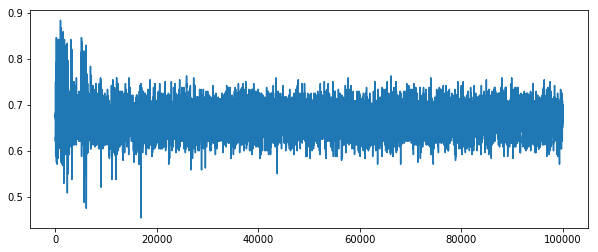

In [10]:
stsize = 40
ntokens = 2
seqlen=4
fpathL = glob('model_data/PITask/LSTM_%s-ntokens_%s-seqlen_%s-ntrials_2-switchmaps_0-seed_*-tracc.npy'%(
                stsize,ntokens,seqlen))
fpathL
plt.close('all')
for fpath in fpathL:
  plt.figure(figsize=(10,4))
  acc = np.load(fpath)
  print(acc.shape)
  try:
    plt.plot(mov_avg(acc,20))
  except:
    pass

# debug

In [9]:
task2 = PMTask_PI(
        nback=0,
        ntokens_pm=1,
        ntokens_og=3,
        stimdim=sdim,
        seed=np.random.randint(3000)
)

trial_len=[3,6]
ntrials=2
tseq,xseq,ytarget = task2.gen_ep_data(trial_len[0],trial_len[1],ntrials)
tseq
xseq
ytarget
ytarget
xseq,ytarget

(tensor([[[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.0363, 0.0136, 0.0660, 0.3173, 0.0419, 0.3405, 0.1029, 0.1626,
           0.6719, 0.0655]],
 
         [[0.0363, 0.0136, 0.0660, 0.3173, 0.0419, 0.3405, 0.1029, 0.1626,
           0.6719, 0.0655]],
 
         [[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.6518, 0.3425, 0.9352, 0.3451, 0.5561, 0.0405, 0.5620, 0.5015,
           0.9624, 0.0759]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.7877, 0.4098, 0.6916, 0.3457, 0.6337, 0.6058, 0.8785, 0.8699,
           0.8837, 0.2707]],
 
         [[0.1719, 0.8870, 0.5752, 0.0701, 0.5685, 0.1652, 0.0370, 0.5273,
           0.7221, 0.3830]],
 
         [[0.7877, 0.4098, 0.6916, 0.3457, 0.6